# Exploratory Data Analysis

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Для обработки текста
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.util import ngrams
import re
import dask.dataframe as dd
import swifter

# Загрузка стоп-слов и токенизаторов NLTK, если они не установлены
#nltk.download('punkt')
#nltk.download('punkt_tab')
#nltk.download('stopwords')

# Для лемматизации
import pymorphy2

# Для облака слов
from wordcloud import WordCloud

# Для снижения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Для аннотации типов
from typing import List, Union, Tuple

# Для POS-теггирования
import spacy
nlp = spacy.load("ru_core_news_sm")

# Для отслеживания процесса обработки данных
from tqdm.auto import tqdm
tqdm.pandas(desc="Обработка текста")

# Отключение ворнингов
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None

# Настройка Прогресс-бара для swifter и dask
swifter.config.progress_bar = True
from dask.diagnostics import ProgressBar

# Для отображения картинки
import gdown
from PIL import Image

## Предварительный анализ данных

### Описание столбцов

- **Title**: Название статьи
- **Author**: Автор статьи
- **Publication_date**: Дата и время публикации статьи
- **Hubs**: Темы (Хабы), к которым относится статья
- **Tags**: Список тегов, описывающих основное содержание статьи
- **Content**: Текст статьи
- **Comments**: Количество комментариев к статье
- **Views**: Количество просмотров статьи
- **URL**: Ссылка на статью
- **Reading_time**: Примерное время чтения статьи в минутах
- **Images_links**: Ссылки на изображения, присутствующие в статье (если есть)
- **Individ/Company**: Написана статья частным лицом (individual) или компанией (company)
- **Rating**: Рейтинг статьи
- **Positive/Negative**: Оценка статьи: позитивная или негативная
- **Bookmarks_cnt**: Количество добавлений статьи в закладки

### Загрузка и обзор данных

In [2]:
# Загрузка данных
df = pd.read_parquet('D:/Datasets/HSE/Project/habr_articles_parsed_final.parquet')

In [3]:
df.head(2)

,Title,Author,Publication_date,Hubs,Tags,Content,Comments,Views,URL,Reading_time,Images_links,Individ/Company,Rating,Positive/Negative,Bookmarks_cnt
0,Лечение приступов лени,complex,2009-08-03 14:34:35+00:00,GTD,"лень, учись работать, самомотивация, мотивация",Пора лишать девственности свой бложик.\nТак ка...,67,6800,https://habr.com/ru/articles/66091/,2.0,,individual,4,positive,25.0
1,Как я работал по два часа в день,Konovalov,2009-07-30 13:50:03+00:00,GTD,"тайм-менеджмент, timemanagement, работа, эффек...",Когда я только перешёл от офисной работы к дом...,99,21000,https://habr.com/ru/articles/65783/,3.0,,individual,193,positive,114.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285499 entries, 0 to 285498
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   Title              285498 non-null  object             
 1   Author             285384 non-null  object             
 2   Publication_date   285498 non-null  datetime64[us, UTC]
 3   Hubs               285499 non-null  object             
 4   Tags               285499 non-null  object             
 5   Content            285498 non-null  object             
 6   Comments           285499 non-null  int64              
 7   Views              285499 non-null  int64              
 8   URL                285499 non-null  object             
 9   Reading_time       284898 non-null  float64            
 10  Images_links       285499 non-null  object             
 11  Individ/Company    285499 non-null  object             
 12  Rating             285499 non-

In [5]:
# Проверим пропуски
df.isna().sum()

Title                  1
Author               115
Publication_date       1
Hubs                   0
Tags                   0
Content                1
Comments               0
Views                  0
URL                    0
Reading_time         601
Images_links           0
Individ/Company        0
Rating                 0
Positive/Negative      0
Bookmarks_cnt          1
dtype: int64

**Выводы**
- В текстах присутствуют пропуски, далее их обработаем
- Для столбца `Bookmarks_cnt` задан тип данных float, переведём его в int
- Оценка статьи (негативная или позитивная) сейчас представлена в отдельном столбце `Positive/Negative`, скорректируем это таким образом, чтобы всё было в одном столбце

## Обработка текстов статей

### Предобработка данных

In [6]:
# Удаление строк с пропусками
df_clean = df.copy()
df_clean = df_clean.dropna()

In [7]:
# Проверка на дубликаты
print(f"Количество дубликатов: {df_clean.duplicated().sum()}")

Количество дубликатов: 0


In [8]:
# Изменение столбца с рейтингом
df_clean.loc[df['Positive/Negative'] == 'negative', 'rating_new'] = -df_clean['Rating']
df_clean.loc[df['Positive/Negative'] == 'positive', 'rating_new'] = df_clean['Rating']

In [9]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 284784 entries, 0 to 285498
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   Title              284784 non-null  object             
 1   Author             284784 non-null  object             
 2   Publication_date   284784 non-null  datetime64[us, UTC]
 3   Hubs               284784 non-null  object             
 4   Tags               284784 non-null  object             
 5   Content            284784 non-null  object             
 6   Comments           284784 non-null  int64              
 7   Views              284784 non-null  int64              
 8   URL                284784 non-null  object             
 9   Reading_time       284784 non-null  float64            
 10  Images_links       284784 non-null  object             
 11  Individ/Company    284784 non-null  object             
 12  Rating             284784 non-null 

In [10]:
# Изменение типов данных в столбце Bookmarks_cnt
df_clean['Bookmarks_cnt'] = df_clean['Bookmarks_cnt'].astype(int)

### Очистка текста от лишних символов

In [11]:
# Функция для очистки текста от лишних символов
def clean_text(text: str) -> str:
    """
    Очищает текст, удаляя HTML-теги, специальные символы, пунктуацию и цифры, приводит текст к нижнему регистру

    Параметры:
    text (str): Исходный текст для очистки

    Возвращает:
    str: Очищенный текст
    """

    # Замена переносов строк на пробелы 
    text = text.replace('\n', ' ')
    # Удаление HTML-тегов
    text = re.sub(r'<.*?>', '', text)
    # Удаление специальных символов, пунктуации
    text = re.sub(r'[^\w\s]', '', text)
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление цифр
    text = re.sub(r'\d+', '', text)
    return text

In [12]:
# Очистка текста статей от лишних символов
df_clean['cleaned_text'] = df_clean['Content'].swifter.apply(clean_text)

Pandas Apply:   0%|          | 0/284784 [00:00<?, ?it/s]

### Удаление статей со слишкой большой или нулевой длиной текста

In [13]:
# Расчет длины текста
df_clean['text_length'] = df_clean['cleaned_text'].apply(len)
df_clean['text_length'].describe()

count    284784.000000
mean       7910.200271
std        8568.120131
min           0.000000
25%        2300.000000
50%        5818.000000
75%       10728.000000
max      742920.000000
Name: text_length, dtype: float64

In [14]:
# Уберём статьи, где длина текста равна нулю
# или она слишком большая для дальнейшего выделения токенов
df_clean = df_clean[(df_clean['text_length'] < 200000)
                    &(df_clean['text_length'] != 0)]

In [15]:
df_clean.head(2)

,Title,Author,Publication_date,Hubs,Tags,Content,Comments,Views,URL,Reading_time,Images_links,Individ/Company,Rating,Positive/Negative,Bookmarks_cnt,rating_new,cleaned_text,text_length
0,Лечение приступов лени,complex,2009-08-03 14:34:35+00:00,GTD,"лень, учись работать, самомотивация, мотивация",Пора лишать девственности свой бложик.\nТак ка...,67,6800,https://habr.com/ru/articles/66091/,2.0,,individual,4,positive,25,4.0,пора лишать девственности свой бложик так как ...,2027
1,Как я работал по два часа в день,Konovalov,2009-07-30 13:50:03+00:00,GTD,"тайм-менеджмент, timemanagement, работа, эффек...",Когда я только перешёл от офисной работы к дом...,99,21000,https://habr.com/ru/articles/65783/,3.0,,individual,193,positive,114,193.0,когда я только перешёл от офисной работы к дом...,3889


### Выделение токенов из текста статей

In [ ]:
# Проведём анализ 10% статей (28к статей)
sample_size = round(len(df_clean) / 10)
sample_df = df_clean.sample(sample_size, random_state=42)
# Преобразование pandas DataFrame в Dask DataFrame
ddf = dd.from_pandas(sample_df, npartitions=100)

In [ ]:
# Загрузка модели spaCy
nlp = spacy.load("ru_core_news_sm", disable=['parser', 'ner'])

# Добавление стоп-слов
stop_words = set(stopwords.words('russian'))
for word in stop_words:
    nlp.vocab[word].is_stop = True

# Определение функции для предобработки текста
def preprocess_text(text: Union[str, float]) -> List[str]:
    """
    Предобрабатывает текст, удаляя стоп-слова и небуквенные токены, лемматизирует оставшиеся слова
    
    Параметры:
        text (Union[str]): Исходный текст для обработки
        
    Возвращает:
        List[str]: Список лемматизированных слов, очищенных от стоп-слов и небуквенных символов
                   Возвращает пустой список, если входное значение является NaN
    """
    if pd.isna(text):
        return []
        
    text = str(text)
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return tokens

In [11]:
with ProgressBar():
    ddf['tokens'] = ddf['cleaned_text'].apply(preprocess_text, meta=('tokens', object))
    result_df = ddf.compute()

[########################################] | 100% Completed | 77.53 s


In [ ]:
result_df.head(2)

,Title,Author,Publication_date,Hubs,Tags,Content,Comments,Views,URL,Reading_time,Images_links,Individ/Company,Rating,Positive/Negative,Bookmarks_cnt,cleaned_text,text_length,tokens
1055,Инструменты реализации API-сервера на Golang с...,klim0v,2020-04-07 10:15:35+00:00,"API, Go, Open source","golang, protobuf, grpc-gateway, swagger, кодог...",Я бы хотел в этой статье рассказать вам о том ...,0,35000,https://habr.com/ru/articles/496098/,13.0,https://habrastorage.org/r/w1560/webt/wm/tp/_y...,individual,11,positive,82.0,я бы хотел в этой статье рассказать вам о том ...,19308,"[статья, рассказать, быстро, сделать, веб, сер..."
1107,Отладка высоконагруженных Golang-приложений ил...,Nastradamus,2020-04-03 10:00:38+00:00,"Блог компании Домклик, Go, Kubernetes, Системн...","kubernetes, golang, ДомКлик, go, k8s","В современном мире Kubernetes-облаков, так или...",18,8600,https://habr.com/ru/companies/domclick/article...,4.0,https://habrastorage.org/r/w780q1/webt/ok/xx/p...,company,30,positive,47.0,в современном мире kubernetesоблаков так или и...,6420,"[современный, мир, kubernetesоблаков, приходит..."


In [ ]:
#result_df.to_parquet('df_tokens.parquet', index=False)

## Исследовательский анализ данных

### Распределение длины текстов

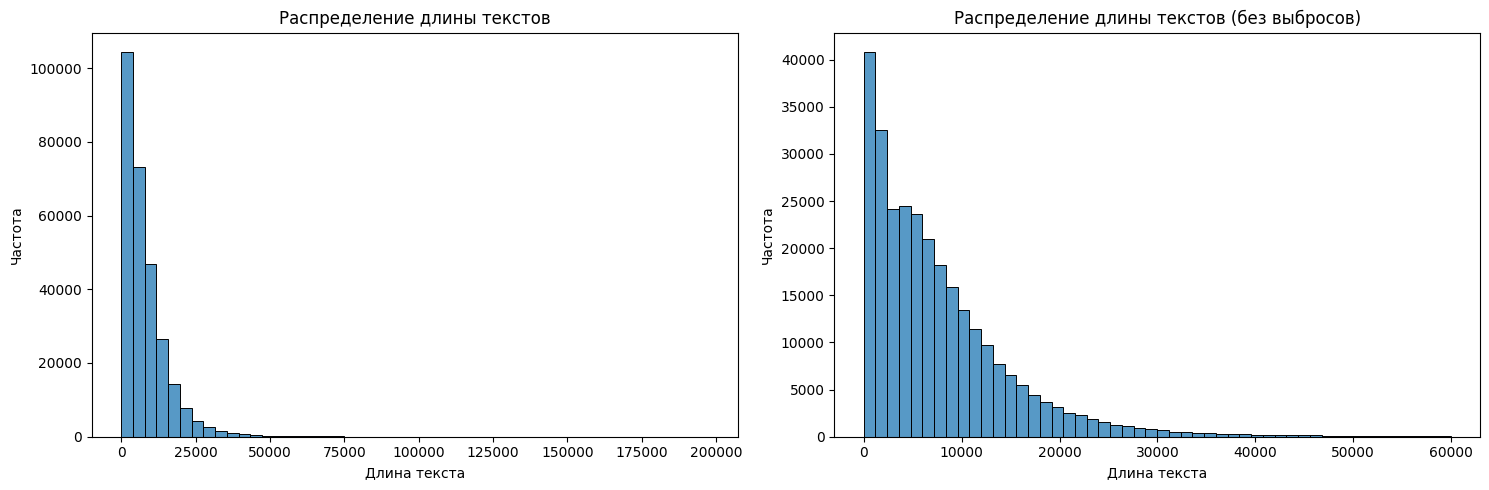

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Визуализация распределения длины текстов
sns.histplot(df_clean['text_length'], bins=50, ax=axes[0])
axes[0].set_title('Распределение длины текстов')
axes[0].set_xlabel('Длина текста')
axes[0].set_ylabel('Частота')

# Визуализация распределения длины текстов (если убрать выбросы)
sns.histplot(df_clean[df_clean['text_length'] < 60000]['text_length'], bins=50)
axes[1].set_title('Распределение длины текстов (без выбросов)')
axes[1].set_xlabel('Длина текста')
axes[1].set_ylabel('Частота')

plt.tight_layout()
plt.show()

In [20]:
df_clean['text_length'].describe()

count    284687.00000
mean       7893.70130
std        8196.48454
min           1.00000
25%        2302.00000
50%        5820.00000
75%       10729.00000
max      197359.00000
Name: text_length, dtype: float64

In [21]:
# Вычисление метрик длины текста
mean_length = round(df_clean['text_length'].mean())
min_length = df_clean['text_length'].min()
max_length = df_clean['text_length'].max()

print(f"Средняя длина текста: {mean_length}")
print(f"Минимальная длина текста: {min_length}")
print(f"Максимальная длина текста: {max_length}")

Средняя длина текста: 7894
Минимальная длина текста: 1
Максимальная длина текста: 197359


**Выводы**
- Большая часть текстов имеет относительно небольшую длину, с резким спадом частоты по мере увеличения длины
- Максимальная частота приходится на тексты длиной в нескольких тысяч символов, затем частота резко падает
- После удаления выбросов можно заметить, что тексты длиной до 10 000 символов составляют значительную часть выборки и частота резко снижается после 20 000 символов
- Средняя длина текста составляет 7 894 символа, что выше медианы (5 820 символов), что указывает на смещённое распределение с длинным "хвостом" в сторону больших значений
- Для текстов с минимальной длиной было проведено дополнительное исследование и было выявлено, что такие тексты валидны, так как в них есть картинки (мемы), пример приведён ниже

Downloading...
From: https://drive.google.com/uc?id=1biuYamY6UDquihowOuM4TIBq_abzykZc
To: c:\Users\dimas\Jupyter\HSE\Habr_project\eda\image.jpg
100%|██████████| 906k/906k [00:00<00:00, 2.03MB/s]


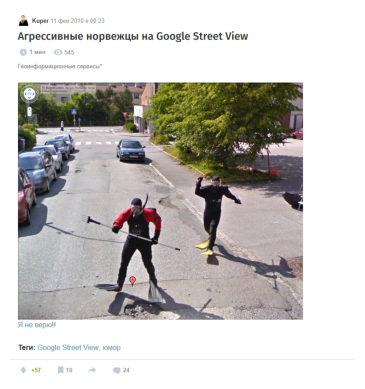

In [22]:
# Пример изображения, где текст статьи всего 3 слова
url = f'https://drive.google.com/uc?id=1biuYamY6UDquihowOuM4TIBq_abzykZc'
output = 'image.jpg'

gdown.download(url, output, quiet=False)
img = Image.open(output)
plt.imshow(img)
plt.axis('off')
plt.show()

### Распределение наиболее частотных слов

In [23]:
# Объединение всех токенов в один список
all_tokens = [token for tokens in result_df['tokens'] for token in tokens]

# Частотное распределение
freq_dist = FreqDist(all_tokens)

# Топ-5 наиболее частотных слов
print(freq_dist.most_common(5))

[('использовать', 75537), ('работа', 71332), ('время', 70637), ('система', 63425), ('год', 62961)]


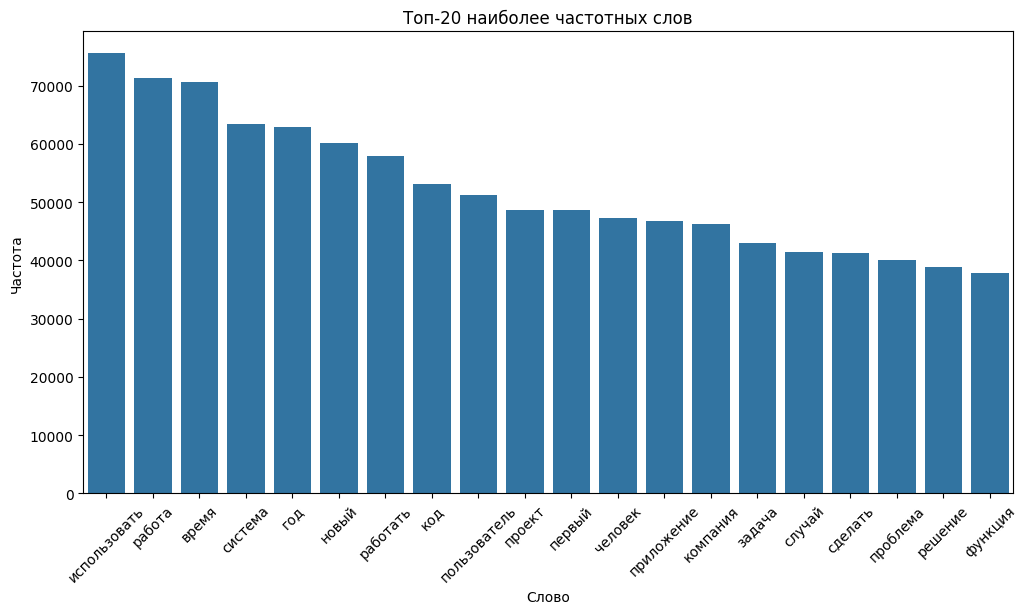

In [24]:
# Распределение наиболее частотных слов
freq_df = pd.DataFrame(freq_dist.most_common(20), columns=['Слово', 'Частота'])
plt.figure(figsize=(12,6))
sns.barplot(x='Слово', y='Частота', data=freq_df)
plt.title('Топ-20 наиболее частотных слов')
plt.xticks(rotation=45)
plt.show()

**Выводы**
- Чаще всего встречаются слова, связанные с деятельностью и процессами («использовать», «работа», «время», «система», «проект», «приложение» и «компания»)
- Слова «код», «пользователь» и «функция» указывают на IT-направленность большинства статей (что логично, ведь наш источник это Хабр)
- В списке присутствуют такие слова, как «человек» и «пользователь», что может указывать на связь текстов с пользователями или клиентами. Это может означать, что тексты обсуждают не только технические аспекты, но и то, как эти аспекты влияют на людей

### Распределение длины текстов

In [25]:
# Количество слов
result_df['word_count'] = result_df['tokens'].apply(len)
# Средняя длина слов
result_df['avg_word_length'] = result_df['tokens'].apply(lambda tokens: np.mean([len(word) for word in tokens]))

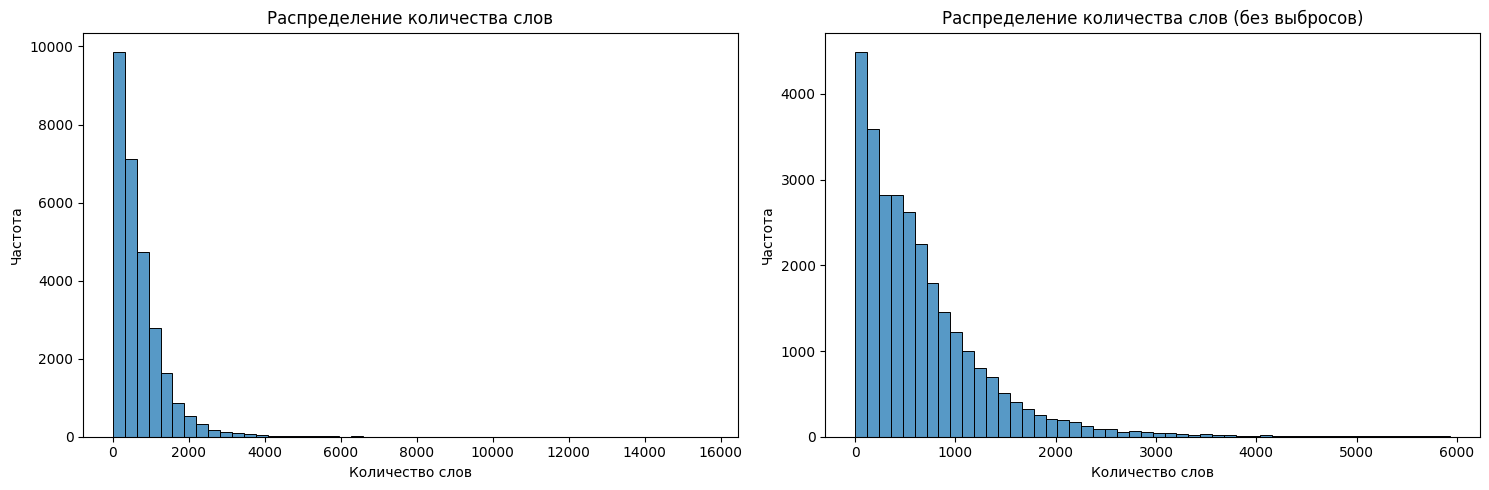

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Распределение длины текстов
sns.histplot(result_df['word_count'], bins=50, ax=axes[0])
axes[0].set_title('Распределение количества слов')
axes[0].set_xlabel('Количество слов')
axes[0].set_ylabel('Частота')

# Распределение длины текстов (без выбросов)
sns.histplot(result_df[result_df['word_count'] < 6000]['word_count'], bins=50, ax=axes[1])
axes[1].set_title('Распределение количества слов (без выбросов)')
axes[1].set_xlabel('Количество слов')
axes[1].set_ylabel('Частота')

plt.tight_layout()
plt.show()

In [27]:
result_df['word_count'].describe()

count    28469.000000
mean       672.371878
std        693.622814
min          0.000000
25%        201.000000
50%        496.000000
75%        910.000000
max      15670.000000
Name: word_count, dtype: float64

**Выводы**
- Большая часть текстов имеет небольшое количество слов, что проявляется в резком пике на начальных значениях и постепенном снижении по мере увеличения количества слов
- Максимальное количество слов в тексте составляет 15 670, что сильно превышает среднее значение, указывая на наличие выбросов
- На графике без выбросов видно, что большинство текстов имеют количество слов менее 2000
- Стандартное отклонение (693) довольно велико, указывает на высокую степень разброса данных, что подтверждается наличием длинного «хвоста» на графиках, где встречаются тексты с большим количеством слов

### Распределение количества статей и длины текстов статей в зависимости от рейтинга

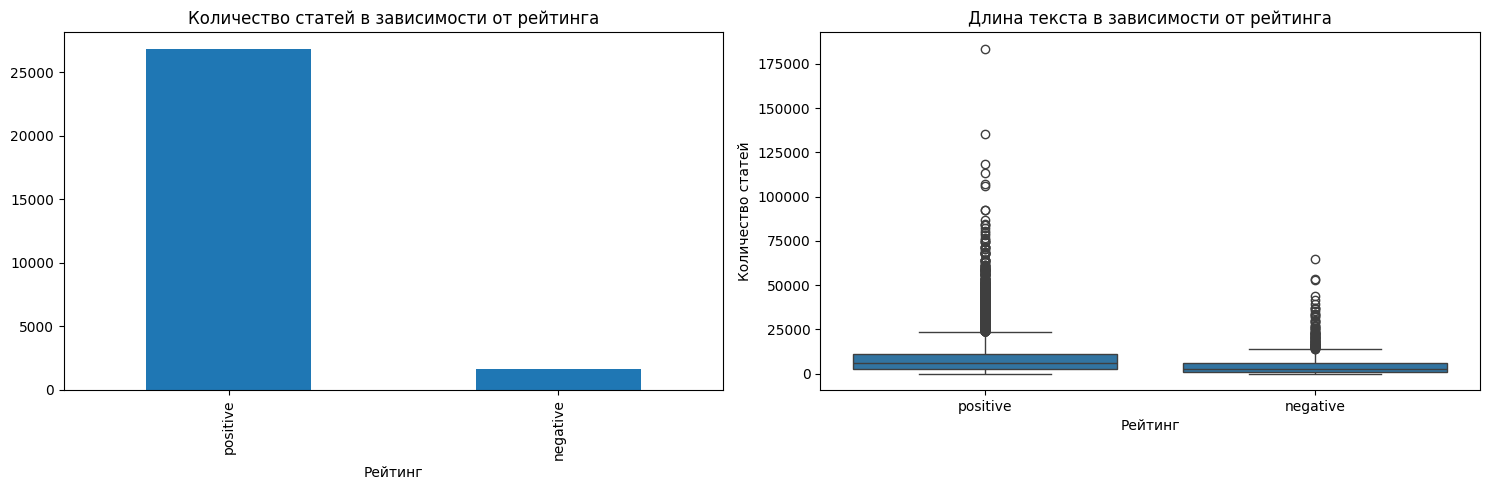

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Распределение количества статей в зависимости от рейтинга
result_df['Positive/Negative'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Количество статей в зависимости от рейтинга')
axes[0].set_xlabel('Рейтинг')

# График сравнения длины текста между классами
sns.boxplot(x='Positive/Negative', y='text_length', data=result_df, ax=axes[1])
axes[1].set_title('Длина текста в зависимости от рейтинга')
axes[1].set_xlabel('Рейтинг')
axes[1].set_ylabel('Количество статей')

plt.tight_layout()
plt.show()

In [29]:
result_df.groupby('Positive/Negative')['text_length'].describe()

,count,mean,std,min,25%,50%,75%,max
Positive/Negative,,,,,,,,
negative,1678.0,4457.727652,5874.653836,2.0,727.25,2695.0,6032.25,64795.0
positive,26791.0,8097.490948,8251.995380,1.0,2450.00,6007.0,10983.00,183557.0


**Выводы**
- Большинство статей имеет рейтинг "positive», в то время как количество статей с рейтингом «negative» значительно меньше, то есть позитивные статьи преобладают в выборке
- На графике boxplot видно, что длины текстов для обеих категорий варьируются в широком диапазоне, и у обеих категорий есть значительное количество выбросов. При этом у статей с рейтингом «positive» разброс значений немного больше (std = 8251), чем у «negative» (std = 5875). Может быть связано с тем, что статей с рейтингом "positive» значительно больше, чем с рейтингом «negative»
- Средняя длина текстов для «positive» — 8 097 символов, что существенно больше, чем для «negative», где средняя длина составляет 4 457 символов. Это может указывать на тенденцию к более детальному изложению в положительных статьях

### Анализ биграмм и триграмм

In [30]:
# Функция для извлечения n-грамм и получения частотного распределения
def get_top_ngrams(df: pd.DataFrame, n: int, top: int = 5) -> List[Tuple[Tuple[str, str], int]]:
    """
    Извлекает n-граммы из списка токенов в DataFrame, 
        рассчитывает частотное распределение и возвращает топ наиболее частотных n-грамм

    Параметры:
    result_df (pd.DataFrame): DataFrame, содержащий столбец 'tokens' с токенами для извлечения n-грамм
    n (int): Длина n-грамм
    top_k (int): Количество наиболее частотных n-грамм для вывода (по умолчанию 5)

    Возвращает:
    List[Tuple[Tuple[str, str], int]]: Список из top_k наиболее частотных n-грамм с их частотой
    """
    # Выделение n-грамм
    df[f'{n}_grams'] = df['tokens'].apply(lambda tokens: list(ngrams(tokens, n)))

    # Объединение всех n-грамм в один список
    all_ngrams = [ngram for ngrams_list in df[f'{n}_grams'] for ngram in ngrams_list]

    # Частотное распределение n-грамм
    freq_dist = FreqDist(all_ngrams)

    return freq_dist.most_common(top)

In [31]:
# Выделение биграмм
top_bigrams = get_top_ngrams(result_df, n=2, top=20)
print('Топ 5 биграмм:', *top_bigrams[:5])

# Выделение триграмм
top_trigrams = get_top_ngrams(result_df, n=3, top=20)
print('Топ 5 триграмм:', *top_trigrams[:5])

Топ 5 биграмм: (('x', 'x'), 14347) (('точка', 'зрение'), 5571) (('обратить', 'внимание'), 4700) (('программный', 'обеспечение'), 3827) (('исходный', 'код'), 3781)
Топ 5 триграмм: (('x', 'x', 'x'), 12554) (('пользователь', 'участвовать', 'опрос'), 1278) (('участвовать', 'опрос', 'войти'), 1276) (('проголосовать', 'пользователь', 'воздержаться'), 1273) (('зарегистрировать', 'пользователь', 'участвовать'), 1211)


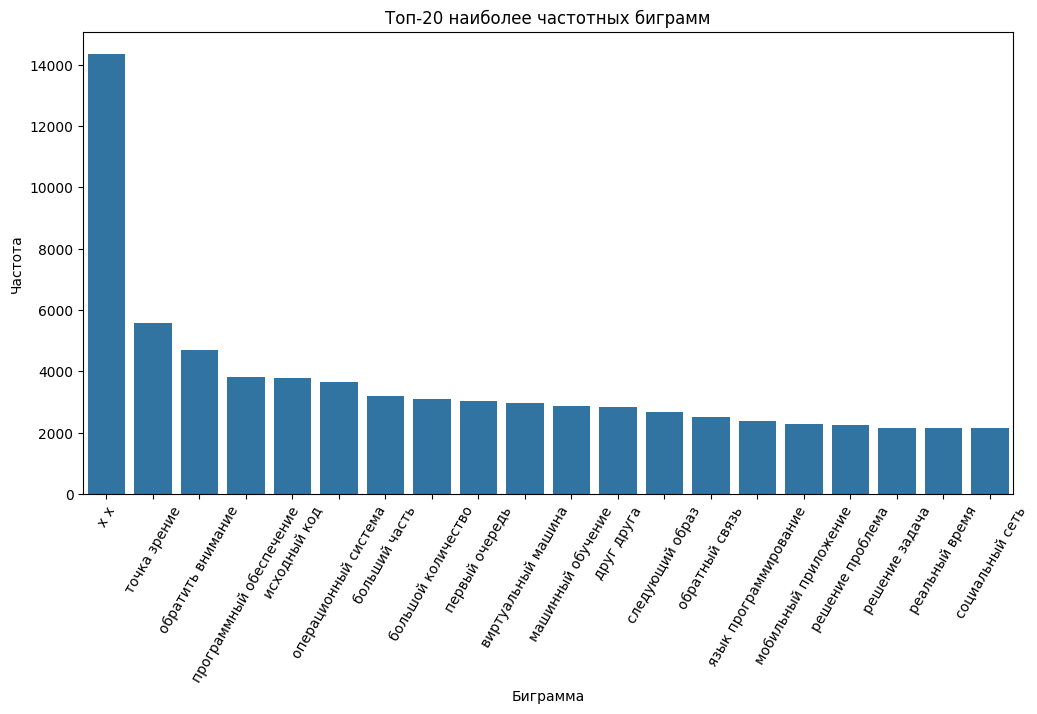

In [32]:
# График частотности биграмм
bigram_freq_df = pd.DataFrame(top_bigrams, columns=['Биграмма', 'Частота'])
bigram_freq_df['Биграмма'] = bigram_freq_df['Биграмма'].apply(lambda x: ' '.join(x))

plt.figure(figsize=(12,6))
sns.barplot(x='Биграмма', y='Частота', data=bigram_freq_df)
plt.title('Топ-20 наиболее частотных биграмм')
plt.xticks(rotation=60)
plt.show()

**Выводы**
- Наиболее частотная биграмма — «x x», которая встречается значительно чаще остальных. Скорее всего это специальный символ, используемый в текстах, не несёт смысловой нагрузки
- Другие часто встречающиеся биграммы включают выражения, такие как «язык программирования», «мобильное приложение», «программное обеспечение», «исходный код» и «операционная система», что снова говорит об основном тематике (IT) статей Хабра
- Появление биграммы «машинное обучение» указывает на популярность этого направления в публикуемых статьях

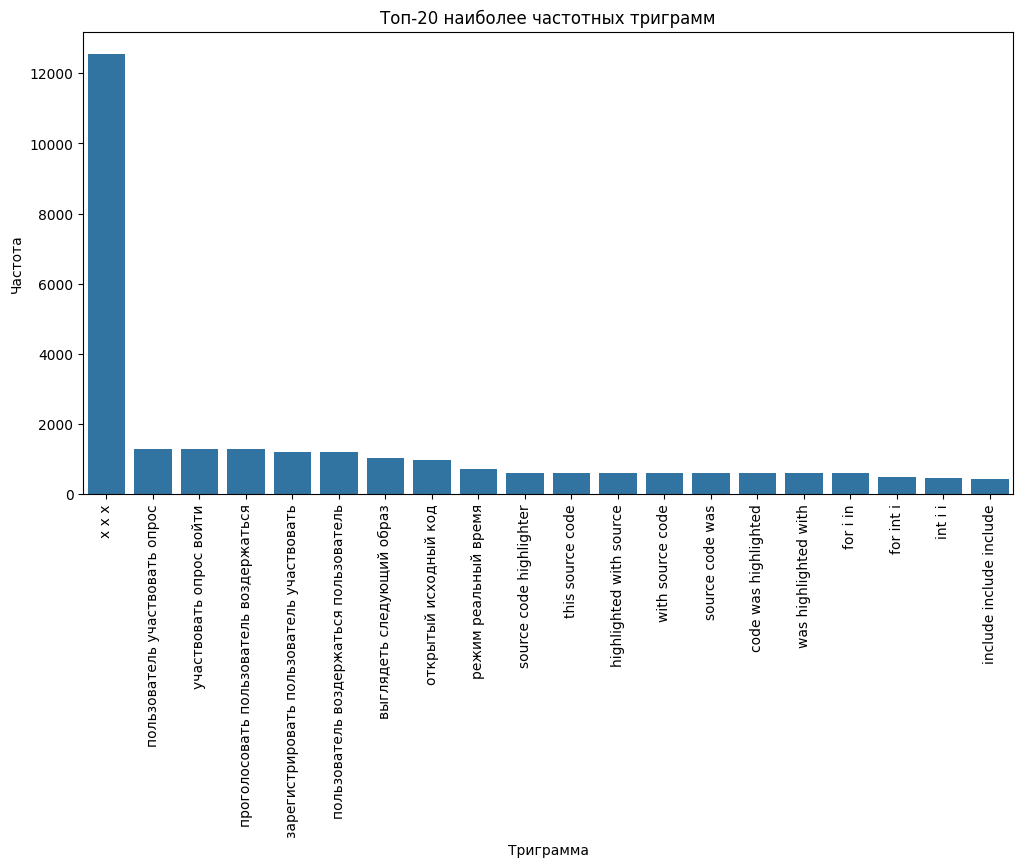

In [33]:
# График частотности триграмм
trigram_freq_df = pd.DataFrame(top_trigrams, columns=['Триграмма', 'Частота'])
trigram_freq_df['Триграмма'] = trigram_freq_df['Триграмма'].apply(lambda x: ' '.join(x))

plt.figure(figsize=(12,6))
sns.barplot(x='Триграмма', y='Частота', data=trigram_freq_df)
plt.title('Топ-20 наиболее частотных триграмм')
plt.xticks(rotation=90)
plt.show()

**Выводы**
- Самая частая триграмма — «x x x», которая также, вероятно, является специальным символом и не несёт смысловой нагрузки
- Среди частых триграмм выделяются выражения, такие как «пользователь участвовать опрос», «проголосовать пользователь», «зарегистрировать пользователь», что может свидетельствовать о текстах, связанных с опросами или анкетированием
- Появление триграмм «режим реальный время», «открытый исходный код» и «source code highlighter» говорит о том, что в текстах обсуждается IT-тематика (снова вспоминаем про основную направленность Хабра)

### Анализ частей речи в текстах статей

In [34]:
# Загружаем модель вне функции, только с нужными модулями
nlp = spacy.load('ru_core_news_sm', disable=['ner', 'parser', 'lemmatizer'])

def get_pos_tags(text: str) -> List[Tuple]:
    """
    Получает POS-теги

    Параметры:
    text (str): Текстовая строка

    Возвращает:
    list: Список кортежей (токен, POS-тег)
    """
    doc = nlp(text)
    return [token.pos_ for token in doc]

In [ ]:
# Преобразуем DataFrame в Dask DataFrame
res_dd = dd.from_pandas(result_df, npartitions=100)

In [17]:
with ProgressBar():
    res_dd['pos_tags'] = res_dd['cleaned_text'].apply(get_pos_tags, meta=('pos_tags', object))
    res_dd = res_dd.compute()

[########################################] | 100% Completed | 14m 58s


In [ ]:
#res_dd.to_parquet('df_pos_tags.parquet_10', index=False)

In [11]:
# Частотное распределение POS-тегов
all_pos_tags = [pos for pos_tags in res_dd['pos_tags'] for pos in pos_tags]
pos_freq_dist = FreqDist(all_pos_tags)

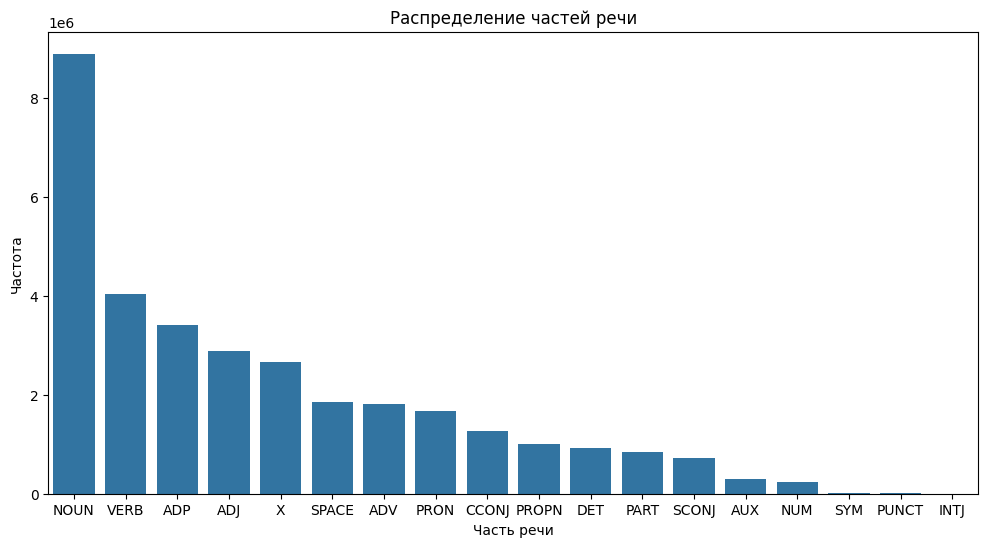

In [14]:
# График распределения частей речи
pos_freq_df = pd.DataFrame(pos_freq_dist.items(), columns=['POS', 'Частота'])
pos_freq_df = pos_freq_df.sort_values(by='Частота', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='POS', y='Частота', data=pos_freq_df)
plt.title('Распределение частей речи')
plt.xlabel('Часть речи')
plt.show()

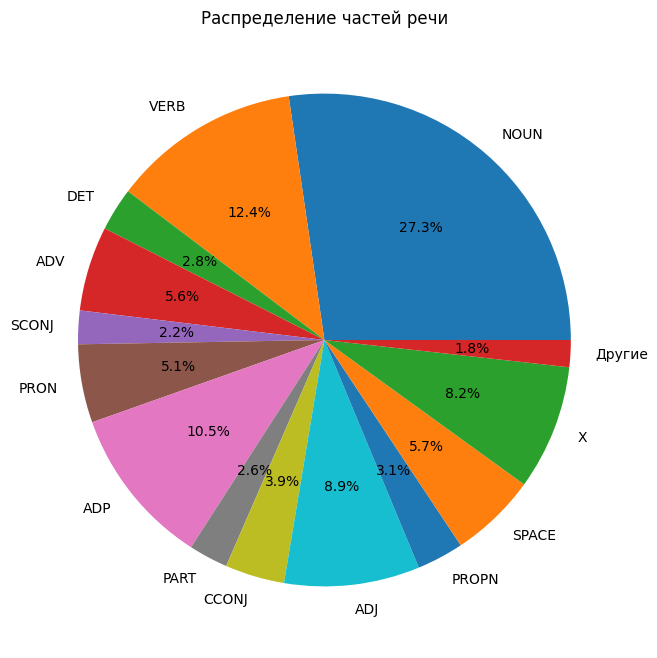

In [35]:
# Круговая диаграмма частей речи
pos_counts = pd.Series(pos_freq_dist)
total_count = pos_counts.sum()
# Фильтрация частей речи, которые занимают менее 1% (и их объединение в категорию "другие")
pos_counts_filter = pos_counts[pos_counts / total_count >= 0.01]
others_count = pos_counts[pos_counts / total_count < 0.01].sum()
if others_count > 0:
    pos_counts_filter['Другие'] = others_count

plt.figure(figsize=(8, 8))
pos_counts_filter.plot(kind='pie', autopct='%1.1f%%')
plt.title('Распределение частей речи')
plt.ylabel('')
plt.show()

In [37]:
pos_counts.sort_values(ascending=False)

NOUN     8887109
VERB     4024154
ADP      3408542
ADJ      2889362
X        2667144
SPACE    1855440
ADV      1807458
PRON     1672111
CCONJ    1270284
PROPN     999488
DET       923272
PART      837606
SCONJ     714985
AUX       304994
NUM       239764
SYM        15826
PUNCT      14391
INTJ         121
dtype: int64

**Выводы**
- Существительные (NOUN) составляют наибольшую долю текста — 27.3% от всех слов, что может указывать, что тексты являются описательным или аналитическими (что характерно для технических статей)
- Глаголы (VERB) составляют значительную часть текста — 12.4%, что может говорить о наличии описания действий или процессов, что логично для текстов, которые описывают рабочие процессы или функционал систем
- Предлоги (ADP) — 8.9%  и прилагательные (ADJ) — 8.2% также встречаются часто, что говорит об описании свойств объектов в статьях
- Слова, которые не удалось отнести к какой-либо из частей речи (X) также встречаются часто — 8.2%, пробельный символ (SPACE) встречается чуть реже 5.7%
- Прочие части речи, такие как наречия (ADV), местоимения (PRON), союзы (CCONJ) и частицы (PART), также присутствуют, но с меньшей частотой
- Части речи, такие как детерминанты (DET), числительные (NUM) и междометия (INTJ), встречаются крайне редко

### Корреляция между числовыми признаками

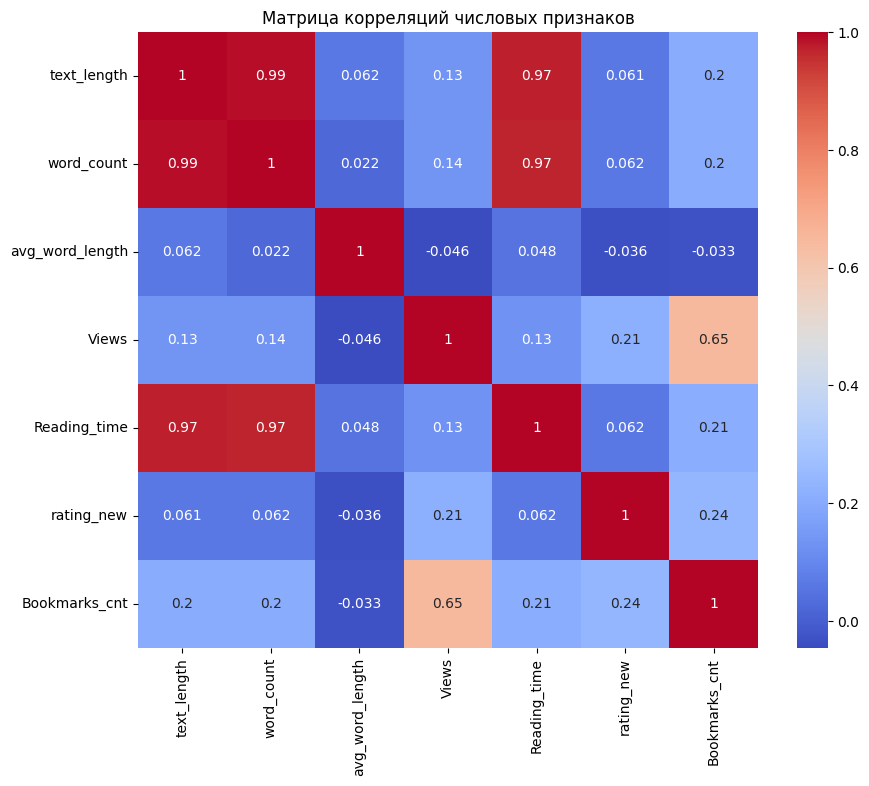

In [11]:
# Выбор числовых признаков для корреляции
num_features = ['text_length', 'word_count', 'avg_word_length', 'Views', 'Reading_time', 'rating_new', 'Bookmarks_cnt']

# Вычисление корреляционной матрицы
corr_matrix = result_df[num_features].corr()

# Построение тепловой карты
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляций числовых признаков')
plt.show()

**Выводы**
- Корреляция между длиной текста (text_length) и количество слов (word_count) очень высокая (0.99), что логично, так как чем больше слов в тексте, тем длиннее текст
- Время прочтения статьи (Reading_time) и длина текста (text_length) также имеют высокую положительную корреляцию (0.97), тоже логично - время чтения текста увеличивается по мере увеличения его длины (аналогично с корреляцией между Reading_time и word_count)
- Время прочтения статьи (Reading_time) и количество слов (word_count) также сильно коррелируют (0.97), также логично, что большее количество слов увеличивает время чтения
- Средняя длина слова (avg_word_length) имеет слабую корреляцию с другими признаками, то есть средняя длина слова почти не связана с длиной текста, количеством просмотров, рейтингом или количеством закладок
- Количество просмотров статьи (Views) и количество добавлений статьи в закладки (Bookmarks_cnt) имеют умеренную положительную корреляцию (0.65), что указывает на то, что тексты с большим количеством просмотров также чаще добавляются в закладки
- Рейтинг (rating_new) имеет слабую положительную корреляцию с Количество просмотров статьи (Views) (0.21) и количеством добавлений статьи в закладки (Bookmarks_cnt) (0.24), что может указывать на то, что тексты с более высоким рейтингом получают чуть больше просмотров и добавлений в закладки, но эта связь незначительная
- Рейтинг (rating_new) почти не коррелирует с длиной текста (0.061), количеством слов (0.062) и временем чтения ((0.062)), что может говорить о том, что качество текста (оценённое через рейтинг) не сильно зависит от его объёма

### Облако слов и биграмм

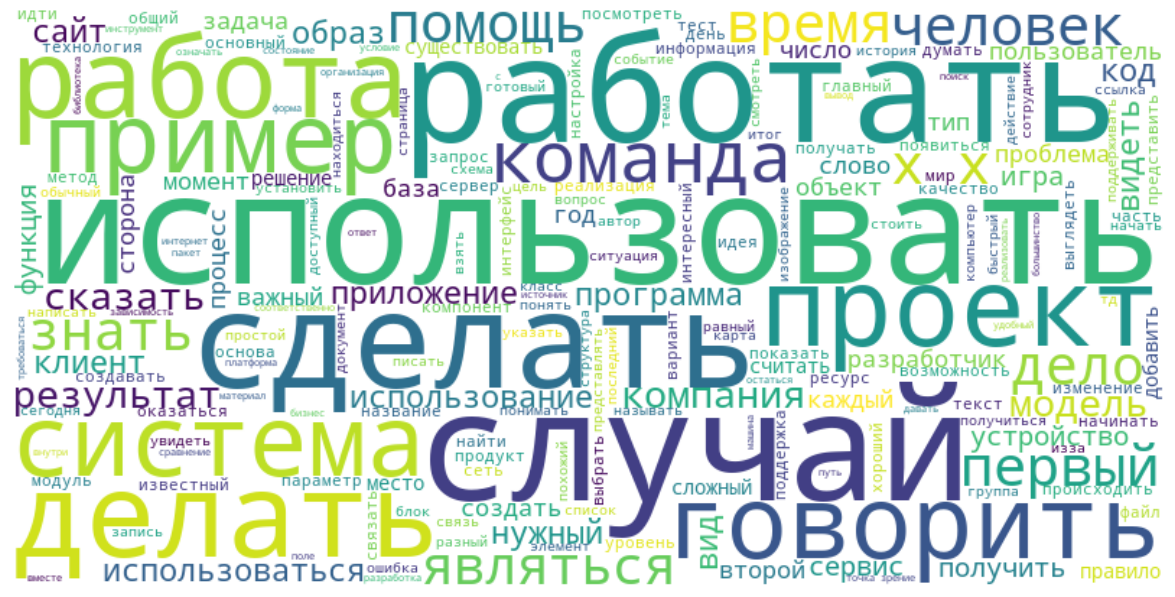

In [ ]:
# Облако слов
all_words = ' '.join([' '.join(tokens) for tokens in result_df['tokens']])

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, stopwords=stop_words).generate(all_words)

plt.figure(figsize=(15,7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Выводы**
- Наиболее частые слова это «работа», «проект», «пример», «использовать», «система», «случай», «делать» и «помощь». Это указывает на акцент на действиях, процессах и проектах, что характерно для IT-тематики статей Хабра
- Глаголы «работать», «делать», «говорить», «видеть», «знать», «сказать», «создавать» и «использовать» также подчеркивают направленность на действия и процессы (в статьях на Хабре часто обсуждаются примеры, инструкции или кейсы)

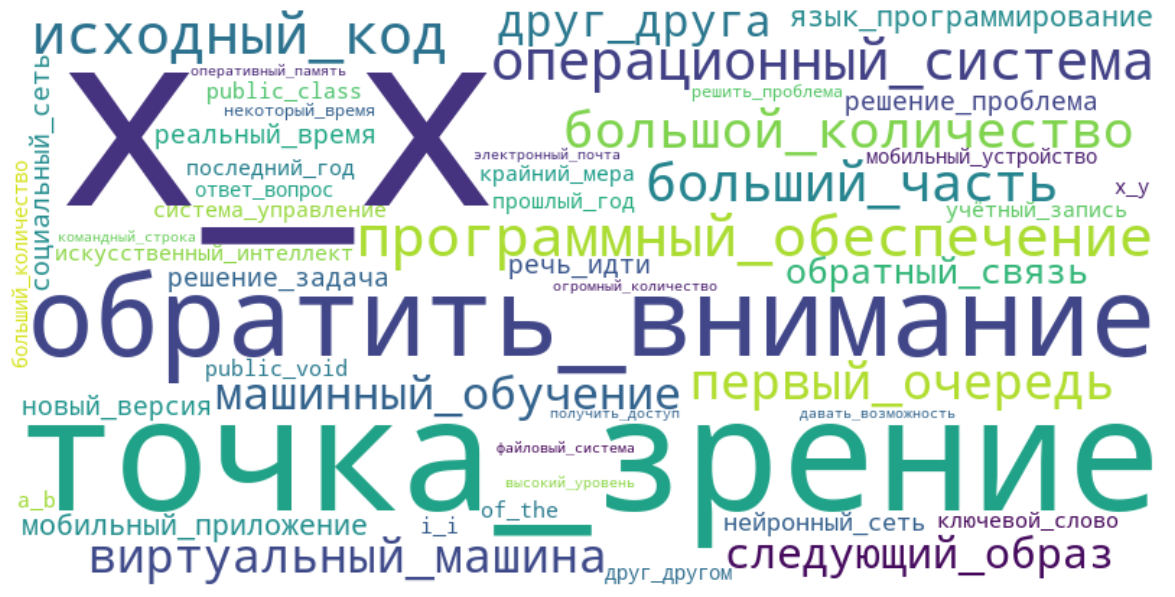

In [59]:
# Облако биграмм
top_bigrams_bigger = get_top_ngrams(result_df, n=2, top=50)
bigram_freq_dict = {'_'.join(bigram): freq for bigram, freq in top_bigrams_bigger}

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_freq_dict)

plt.figure(figsize=(15,7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Выводы**
- В этом облаке биграмм выделяются термины, связанные с IT и программированием, такие как «исходный код», «программное обеспечение», «операционная система», «машинное обучение», «виртуальная машина», «нейронная сеть», «язык программирования» и «файловая система» (основная направленность статей на Хабре)

## Общие выводы по этапу EDA

**Основные выводы о структуре и особенностях данных**
- Для анализа статей был выбран сайт Хабр, где основной тематикой являются программирование, ИТ и смежные технологии. Это подтверждается частотным распределением слов, биграмм и триграмм, где преобладают термины, связанные с ИТ: «исходный код», «машинное обучение», «операционная система», «искусственный интеллект» и др
- Тексты на Хабре сильно варьируются по длине. Несмотря на преобладание коротких и средних текстов, наблюдается значительное количество длинных статей, что может указывать на формат подробных технических или аналитических обзоров
- Распределение длин текстов имеет «тяжёлый хвост» с выбросами, что связано с присутствием длинных статей
- Преобладание существительных и глаголов подтверждает технический и описательный характер текстов. Высокая частотность существительных указывает на акцент на объектах, понятиях и терминах, в то время как глаголы демонстрируют фокус на описании действий и процессов
- Части речи, связанные с эмоциональной окраской (междометия и числительные), встречаются крайне редко, что характерно для технического стиля и ещё раз подтверждает аналитическую направленность контента
- Умеренная положительная корреляция между числом просмотров и числом добавлений в закладки (0,65) говорит о том, что более популярные статьи, как правило, более полезны для пользователей, поэтому их чаще сохраняют в закладки
- Сильная корреляция между количеством слов, длиной текста и временем чтения ожидаема и логична, так как длинные тексты требуют больше времени на чтение. Однако такие признаки, как средняя длина слова, слабо коррелируют с другими параметрами

**Потенциальные проблемы и ограничения**
- Наличие длинных текстов и значительных выбросов может затруднить анализ и потребовать дополнительной обработки. Длинные статьи могут влиять на равномерность распределения признаков и увеличивать дисперсию, поэтому может потребоваться использование методов нормализации или обрезки текста
- Частое появление символов «x x x» и схожих технических терминов может указывать на наличие артефактов в данных (спецсимволы, метки кода), что может добавлять «шум» в текстовый анализ. Перед обработкой данных может потребоваться очистка корпуса от лишних символов или разделение текста и кода
- В текстах присутствуют как короткие описания, так и длинные статьи, что создаёт неоднородность в структуре данных. Это может затруднить их обработку и анализ, особенно при использовании моделей машинного обучения, которые предполагают более однородный входной формат